In [1]:
%matplotlib inline


# Pipelines with auto_arima



Like scikit-learn, ``pmdarima`` can fit "pipeline" models. That is, a pipeline
constitutes a list of arbitrary length comprised of any number of
``BaseTransformer`` objects strung together ordinally, and finished with an
``AutoARIMA`` object.

The benefit of a pipeline is the ability to condense a complex sequence of
stateful transformations into a single object that can call ``fit``,
``predict`` and ``update``. It can also be serialized into *one* pickle file,
which greatly simplifies your life.

.. raw:: html

   <br/>



In [2]:
print(__doc__)

# Author: Taylor Smith <taylor.smith@alkaline-ml.com>

import numpy as np
import pmdarima as pm
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima
from matplotlib import pyplot as plt

print("pmdarima version: %s" % pm.__version__)

# Load the data and split it into separate pieces
data = pm.datasets.load_wineind()
train, test = model_selection.train_test_split(data, train_size=150)



Automatically created module for IPython interactive environment
pmdarima version: 1.8.2


In [5]:
len(data)

176

In [3]:
len(train)

150

In [4]:
len(test)

26

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2819.938, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2942.625, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2867.514, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2830.585, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2940.651, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2817.535, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2814.904, Time=0.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2818.704, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2817.377, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2815.283, Time=0.23 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 4.066 seconds
Model fit:
Pipeline(steps=[('fourier', FourierFeaturizer(k=4, m=12)),
                ('arima',
                 AutoARIMA(error_action='ignore', seasonal=Fals

C:\Users\Mike\.conda\envs\cap1\lib\site-packages\pmdarima\arima\arima.py:577: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


[26536.07429453 34421.90733173 33695.12269782 21269.19320732
 19950.94735913 26081.89537575 25620.13997092 24414.23976021
 26098.84068315 28871.59618789 30770.6309163 ]


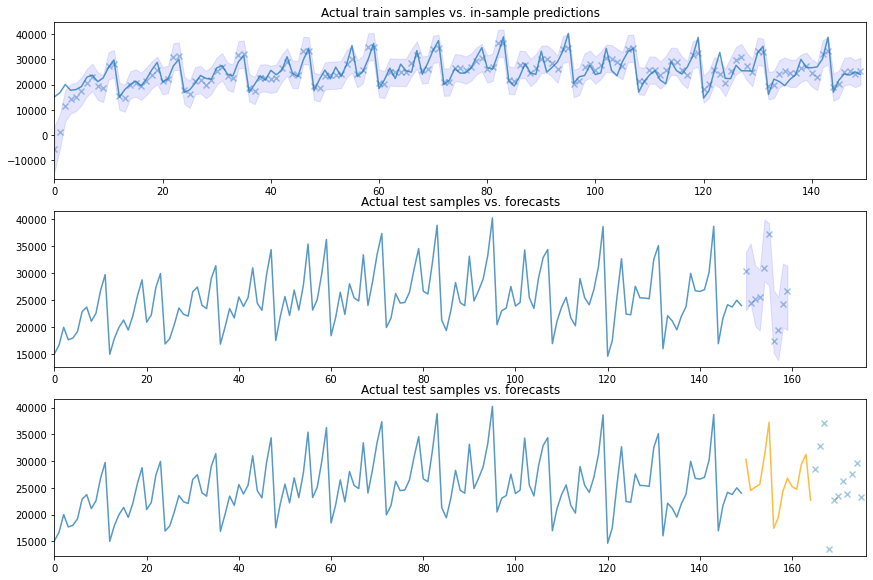

In [6]:
# Let's create a pipeline with multiple stages... the Wineind dataset is
# seasonal, so we'll include a FourierFeaturizer so we can fit it without
# seasonality
pipe = pipeline.Pipeline([
    ("fourier", ppc.FourierFeaturizer(m=12, k=4)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1, error_action="ignore",
                              seasonal=False,  # because we use Fourier
                              suppress_warnings=True))
])

pipe.fit(train)
print("Model fit:")
print(pipe)

# We can compute predictions the same way we would on a normal ARIMA object:
preds, conf_int = pipe.predict(n_periods=10, return_conf_int=True)
print("\nForecasts:")
print(preds)

# Let's take a look at the actual vs. the predicted values:
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

# Visualize goodness of fit
in_sample_preds, in_sample_confint = \
    pipe.predict_in_sample(X=None, return_conf_int=True)

n_train = train.shape[0]

x0 = np.arange(n_train)
axes[0].plot(x0, train, alpha=0.75)
axes[0].scatter(x0, in_sample_preds, alpha=0.4, marker='x')
axes[0].fill_between(x0, in_sample_confint[:, 0], in_sample_confint[:, 1],
                     alpha=0.1, color='b')
axes[0].set_title('Actual train samples vs. in-sample predictions')
axes[0].set_xlim((0, x0.shape[0]))

# Visualize actual + predicted
x1 = np.arange(n_train + preds.shape[0])
axes[1].plot(x1[:n_train], train, alpha=0.75)
# axes[1].scatter(x[n_train:], preds, alpha=0.4, marker='o')
axes[1].scatter(x1[n_train:], test[:preds.shape[0]], alpha=0.4, marker='x')
axes[1].fill_between(x1[n_train:], conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')
axes[1].set_title('Actual test samples vs. forecasts')
axes[1].set_xlim((0, data.shape[0]))

# We can also call `update` directly on the pipeline object, which will update
# the intermittent transformers, where necessary:
newly_observed, still_test = test[:15], test[15:]
pipe.update(newly_observed, maxiter=10)

# Calling predict will now predict from newly observed values
new_preds = pipe.predict(still_test.shape[0])
print(new_preds)

x2 = np.arange(data.shape[0])
n_trained_on = n_train + newly_observed.shape[0]

axes[2].plot(x2[:n_train], train, alpha=0.75)
axes[2].plot(x2[n_train: n_trained_on], newly_observed, alpha=0.75, c='orange')
# axes[2].scatter(x2[n_trained_on:], new_preds, alpha=0.4, marker='o')
axes[2].scatter(x2[n_trained_on:], still_test, alpha=0.4, marker='x')
axes[2].set_title('Actual test samples vs. forecasts')
axes[2].set_xlim((0, data.shape[0]))

plt.show()